<a href="https://colab.research.google.com/github/KeremAydin98/beating-food101-paper/blob/main/DeepFoodPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check the GPU

We are going to use mixed precision method therefore we need a GPU score over 7.0 and the only GPU which applies to this rule that Google Colab offers is Tesla T4. 

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5c0728cf-d769-745b-017f-61af5f802743)


# Import the data

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train[:50%]", "validation[:50%]"],
                                             shuffle_files= True,
                                             as_supervised = True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIQSTJ7/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIQSTJ7/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
class_names = ds_info.features['label'].names

In [ ]:
class_names

In [5]:
one_sample = train_data.take(1)
one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Image shaoe: (306, 512, 3)
Label: cup_cakes



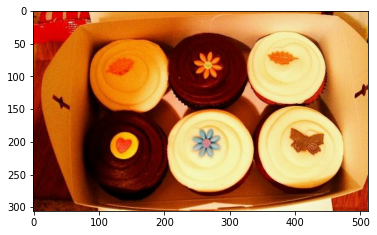

In [7]:
import matplotlib.pyplot as plt
for image, label in one_sample:

  print(f"Image shaoe: {image.shape}")
  print(f"Label: {class_names[label]}\n")

  plt.imshow(image.numpy()/255)

In [8]:
import tensorflow as tf

In [9]:
def preprocess_data(image, label):

  image = tf.image.resize(image, [224,224])

  return tf.cast(image, tf.float32), label

### Batch and Prepare dataset

In [10]:
train_data = train_data.map(map_func=preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Set up mixed precision policy 
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [12]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [13]:
base_model = EfficientNetB0(include_top=False)

base_model.trainable = False

16719872/16705208 [==============================] - 1s 0us/step


In [14]:
# Build a feature extractor

inputs = tf.keras.layers.Input(shape=(224,224,3))

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(len(class_names), activation='softmax',dtype=tf.float32)(x)

model = tf.keras.models.Model(inputs,outputs)

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [15]:
# Create a model checkpoint

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints/cp.ckpt",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      seve_weights_only=True,
                                                      verbose = 0)

In [16]:
initial_epochs = 5

In [17]:
for layer in model.layers:

  print("Layer name: ", layer.name)
  print(f"Layer policy: {layer.dtype_policy}\n")


Layer name:  input_2
Layer policy: <Policy "float32">

Layer name:  efficientnetb0
Layer policy: <Policy "mixed_float16">

Layer name:  global_average_pooling2d
Layer policy: <Policy "mixed_float16">

Layer name:  dense
Layer policy: <Policy "float32">



In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
history_0 = model.fit(train_data, epochs = initial_epochs, steps_per_epoch=len(train_data),
                        validation_data=test_data, validation_steps=int(0.25 * len(test_data)),
                        callbacks=model_checkpoint)

Epoch 1/5
1184/1184 [==============================] - ETA: 0s - loss: 2.1679 - accuracy: 0.4898INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


1184/1184 [==============================] - 152s 113ms/step - loss: 2.1679 - accuracy: 0.4898 - val_loss: 1.4364 - val_accuracy: 0.6307
Epoch 2/5
1183/1184 [============================>.] - ETA: 0s - loss: 1.4736 - accuracy: 0.6243INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


1184/1184 [==============================] - 126s 104ms/step - loss: 1.4734 - accuracy: 0.6244 - val_loss: 1.2894 - val_accuracy: 0.6594
Epoch 3/5
1183/1184 [============================>.] - ETA: 0s - loss: 1.2855 - accuracy: 0.6676INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


1184/1184 [==============================] - 124s 103ms/step - loss: 1.2854 - accuracy: 0.6676 - val_loss: 1.2150 - val_accuracy: 0.6773
Epoch 4/5
1184/1184 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.6983INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


1184/1184 [==============================] - 123s 103ms/step - loss: 1.1628 - accuracy: 0.6983 - val_loss: 1.2030 - val_accuracy: 0.6853
Epoch 5/5
1184/1184 [==============================] - ETA: 0s - loss: 1.0704 - accuracy: 0.7210INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cp.ckpt/assets


1184/1184 [==============================] - 123s 102ms/step - loss: 1.0704 - accuracy: 0.7210 - val_loss: 1.1815 - val_accuracy: 0.6872


In [20]:
feature_extractor_results = model.evaluate(test_data)
feature_extractor_results

395/395 [==============================] - 27s 64ms/step - loss: 1.1581 - accuracy: 0.6926


[1.158128023147583, 0.692594051361084]

### Fine tune our model:

- Model 1: Last 3 layers trainable
- Model 2: Last 5 layers trainable
- Model 3: Last 10 layers trainable

### Model 1

In [21]:
base_model.trainable = True

for layer in base_model.layers[:-3]:

  layer.trainable = False

In [22]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [23]:
history_1 = model.fit(train_data, epochs = initial_epochs + 5, initial_epoch=history_0.epoch[-1], steps_per_epoch=len(train_data),
                        validation_data=test_data, validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
1184/1184 [==============================] - 97s 74ms/step - loss: 1.0083 - accuracy: 0.7409 - val_loss: 1.1225 - val_accuracy: 0.7054
Epoch 6/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.9049 - accuracy: 0.7654 - val_loss: 1.1004 - val_accuracy: 0.7076
Epoch 7/10
1184/1184 [==============================] - 87s 72ms/step - loss: 0.8443 - accuracy: 0.7820 - val_loss: 1.0996 - val_accuracy: 0.7079
Epoch 8/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.7946 - accuracy: 0.7955 - val_loss: 1.1088 - val_accuracy: 0.7031
Epoch 9/10
1184/1184 [==============================] - 89s 74ms/step - loss: 0.7468 - accuracy: 0.8087 - val_loss: 1.0825 - val_accuracy: 0.7127
Epoch 10/10
1184/1184 [==============================] - 89s 74ms/step - loss: 0.7094 - accuracy: 0.8200 - val_loss: 1.0942 - val_accuracy: 0.7127


In [24]:
fine_tune_3_results = model.evaluate(test_data)
fine_tune_3_results

395/395 [==============================] - 27s 64ms/step - loss: 1.0577 - accuracy: 0.7161


[1.0577366352081299, 0.7161188125610352]

### Model 2

In [25]:
# Load checkpoints

model.load_weights("checkpoints/cp.ckpt")

In [27]:
for layer in base_model.layers:

  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [29]:
base_model.traianable = True

for layer in base_model.layers[:-5]:

  layer.trainable = False

In [30]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [32]:
history_2 = model.fit(train_data, epochs = initial_epochs + 5, initial_epoch=history_0.epoch[-1], steps_per_epoch=len(train_data),
                        validation_data=test_data, validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
1184/1184 [==============================] - 97s 76ms/step - loss: 1.0058 - accuracy: 0.7430 - val_loss: 1.1207 - val_accuracy: 0.7060
Epoch 6/10
1184/1184 [==============================] - 90s 75ms/step - loss: 0.9061 - accuracy: 0.7648 - val_loss: 1.0970 - val_accuracy: 0.7079
Epoch 7/10
1184/1184 [==============================] - 89s 74ms/step - loss: 0.8441 - accuracy: 0.7819 - val_loss: 1.1013 - val_accuracy: 0.7047
Epoch 8/10
1184/1184 [==============================] - 90s 74ms/step - loss: 0.7955 - accuracy: 0.7943 - val_loss: 1.0583 - val_accuracy: 0.7143
Epoch 9/10
1184/1184 [==============================] - 89s 74ms/step - loss: 0.7539 - accuracy: 0.8068 - val_loss: 1.0733 - val_accuracy: 0.7124
Epoch 10/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.7169 - accuracy: 0.8166 - val_loss: 1.0794 - val_accuracy: 0.7136


In [33]:
fine_tune_5_results = model.evaluate(test_data)
fine_tune_5_results

395/395 [==============================] - 31s 75ms/step - loss: 1.0557 - accuracy: 0.7177


[1.0557420253753662, 0.7177029848098755]

### Model 3 

In [34]:
# Load checkpoints

model.load_weights("checkpoints/cp.ckpt")

In [35]:
base_model.trainable = True

for layer in base_model.layers[:-10]:

  layer.trainable = False

In [36]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [37]:
history_3 = model.fit(train_data, epochs = initial_epochs + 5, initial_epoch=history_0.epoch[-1], steps_per_epoch=len(train_data),
                        validation_data=test_data, validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
1184/1184 [==============================] - 95s 74ms/step - loss: 1.0017 - accuracy: 0.7392 - val_loss: 1.0939 - val_accuracy: 0.7105
Epoch 6/10
1184/1184 [==============================] - 89s 73ms/step - loss: 0.8660 - accuracy: 0.7746 - val_loss: 1.0738 - val_accuracy: 0.7156
Epoch 7/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.7739 - accuracy: 0.8007 - val_loss: 1.0447 - val_accuracy: 0.7267
Epoch 8/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.7037 - accuracy: 0.8199 - val_loss: 1.0566 - val_accuracy: 0.7181
Epoch 9/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.6449 - accuracy: 0.8369 - val_loss: 1.0360 - val_accuracy: 0.7178
Epoch 10/10
1184/1184 [==============================] - 88s 73ms/step - loss: 0.5831 - accuracy: 0.8537 - val_loss: 1.0378 - val_accuracy: 0.7235


In [38]:
fine_tune_10_results = model.evaluate(test_data)
fine_tune_10_results

395/395 [==============================] - 26s 62ms/step - loss: 1.0265 - accuracy: 0.7237


[1.0264896154403687, 0.7237227559089661]

In [41]:
fine_tune_10_results[1]

0.7237227559089661

In [46]:
import matplotlib.pyplot as plt


accuracies = {"baseline model":feature_extractor_results[1],
              "Fine tune 3 layers":fine_tune_3_results[1],
              "Fine tune 5 layers":fine_tune_5_results[1],
              "Fine tune 10 layers":fine_tune_10_results[1]}
accuracies

{'Fine tune 10 layers': 0.7237227559089661,
 'Fine tune 3 layers': 0.7161188125610352,
 'Fine tune 5 layers': 0.7177029848098755,
 'baseline model': 0.692594051361084}

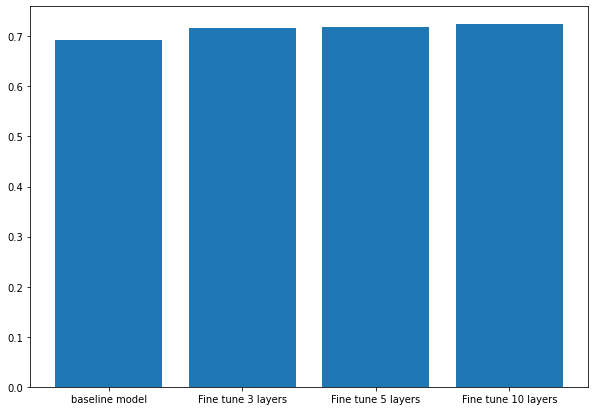

In [49]:

names = list(accuracies.keys())
values = list(accuracies.values())

plt.figure(figsize=(10,7))
plt.bar(range(len(accuracies)),values, tick_label=names)
plt.show()